In [1]:
import csv
import math
import pandas as pd
import json
from socket import timeout

import numpy as np
import heartpy as hp
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import urllib.request
from scipy.signal import resample
from datetime import timezone, timedelta, datetime

In [2]:
activities_df = pd.read_csv('datas/CH-053a.csv')

activities_timestamps = {
    'start': pd.to_datetime(activities_df.iloc[0][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),
    'end': pd.to_datetime(activities_df.iloc[-1][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),
}

/var/folders/8f/j64d6tp11l35pf3_b05vxb0c0000gn/T/ipykernel_86440/621133427.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'start': pd.to_datetime(activities_df.iloc[0][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),
/var/folders/8f/j64d6tp11l35pf3_b05vxb0c0000gn/T/ipykernel_86440/621133427.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'end': pd.to_datetime(activities_df.iloc[-1][2], unit='ms', utc=True).tz_convert(timezone(timedelta(hours=2))),


In [6]:
df = pd.read_csv('datas/CH-053.csv')
df.keys()

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('Europe/Paris')

# Filter the dataframe
filtered_df = df.loc[(df['timestamp'] > activities_timestamps['start']) & (df['timestamp'] < activities_timestamps['end'])]


In [7]:
# Assuming df is your original dataframe
# df['ppg'] = df[['eje_x', 'eje_y']].mean(axis=1)
df['ppg'] = df[['eje_x']]

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Format timestamp
df['timestamp'] = df['timestamp'].dt.strftime('%H:%M:%S.%f')

# Create new dataframe with mean_eje_xy and timestamp
new_df = df[['ppg', 'timestamp']]

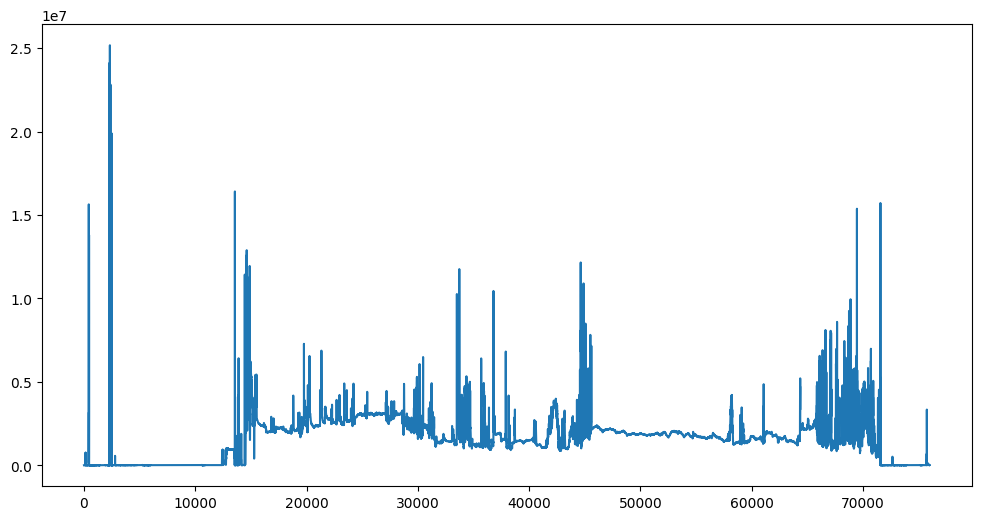

In [8]:
plt.figure(figsize=(12,6))

plt.plot(new_df['ppg'].values)
plt.show()

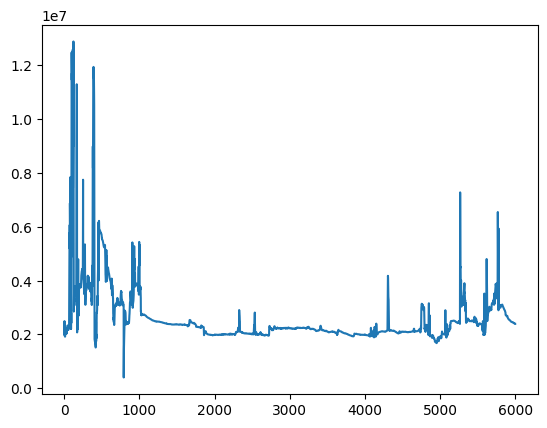

In [9]:
signal = df['ppg'].values[14500:20500]
timer = df['timestamp'].values[14500:20500]
plt.plot(signal)
plt.show()

In [10]:
sample_rate = hp.get_samplerate_datetime(timer, timeformat = '%H:%M:%S.%f')

print('sampling rate is: %.3f Hz' %sample_rate)

sampling rate is: 20.870 Hz


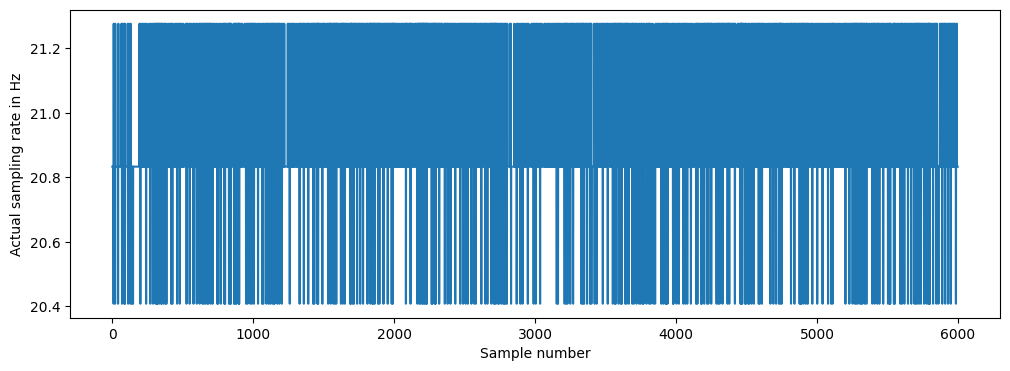

mean sampling rate: 20.868
median sampling rate: 20.833
standard deviation: 0.180


In [11]:
from datetime import datetime

#let's create a list 'newtimer' to house our datetime objects
newtimer = [datetime.strptime(x, '%H:%M:%S.%f') for x in timer]

#let's compute the real distances from entry to entry
elapsed = []
for i in range(len(newtimer) - 1):
    elapsed.append(1 / ((newtimer[i+1] - newtimer[i]).microseconds / 1000000))

#and plot the results
plt.figure(figsize=(12,4))
plt.plot(elapsed)
plt.xlabel('Sample number')
plt.ylabel('Actual sampling rate in Hz')
plt.show()

print('mean sampling rate: %.3f' %np.mean(elapsed))
print('median sampling rate: %.3f'%np.median(elapsed))
print('standard deviation: %.3f'%np.std(elapsed))

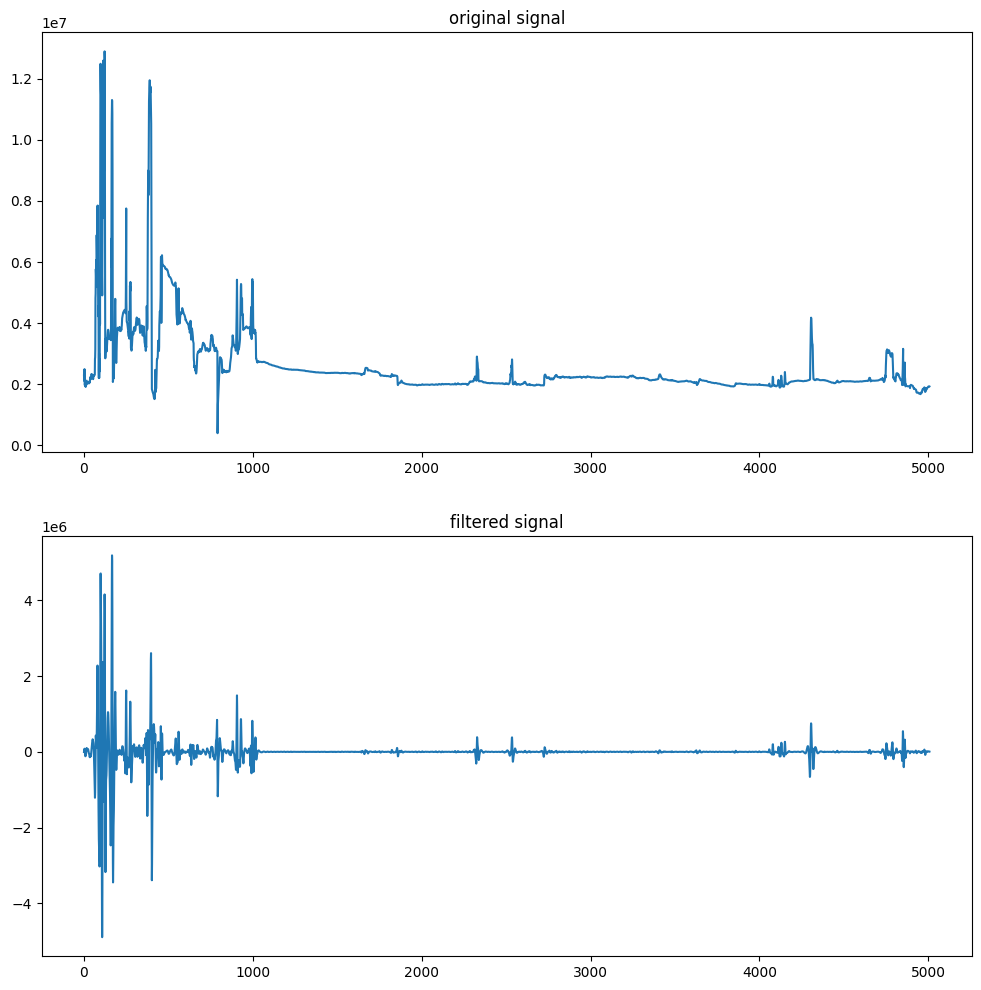

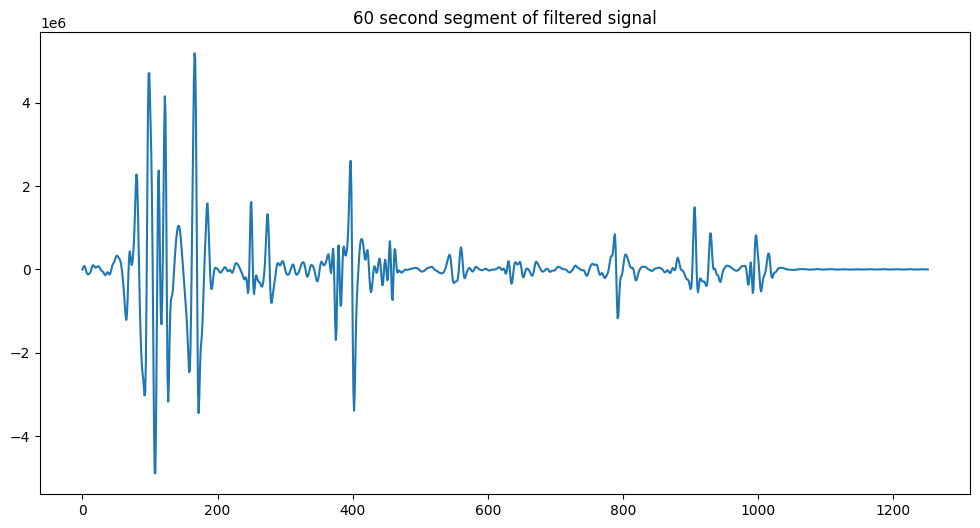

In [12]:
filtered = hp.filter_signal(signal, [0.7, 3.5], sample_rate=sample_rate,
                            order=3, filtertype='bandpass')

#let's plot first 240 seconds and work with that!
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(signal[0:int(240 * sample_rate)])
plt.title('original signal')
plt.subplot(212)
plt.plot(filtered[0:int(240 * sample_rate)])
plt.title('filtered signal')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered[0:int(sample_rate * 60)])
plt.title('60 second segment of filtered signal')
plt.show()


In [13]:
#let's resample to ~100Hz as well
#10Hz is low for the adaptive threshold analysis HeartPy uses
from scipy.signal import resample

resampled = resample(filtered, len(filtered) * 5)

#don't forget to compute the new sampling rate
new_sample_rate = sample_rate * 5

In [14]:
#run HeartPy over a few segments, fingers crossed, and plot results of each
for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
    wd, m = hp.process(resampled[s[0]:s[1]], sample_rate = new_sample_rate,
                       high_precision=True, clean_rr=True)
    hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    hp.plot_poincare(wd, m)
    plt.show()
    for measure in m.keys():
        print('%s: %f' %(measure, m[measure]))


BadSignalWarning: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------


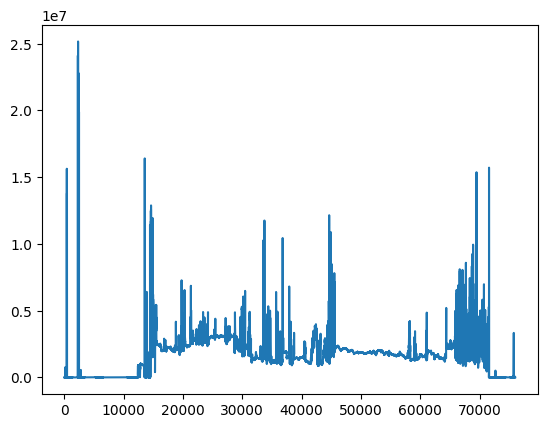

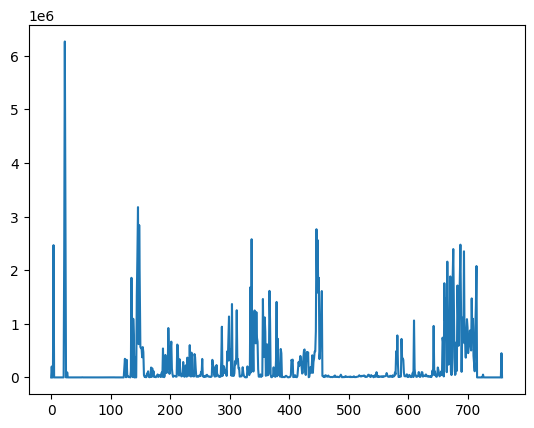

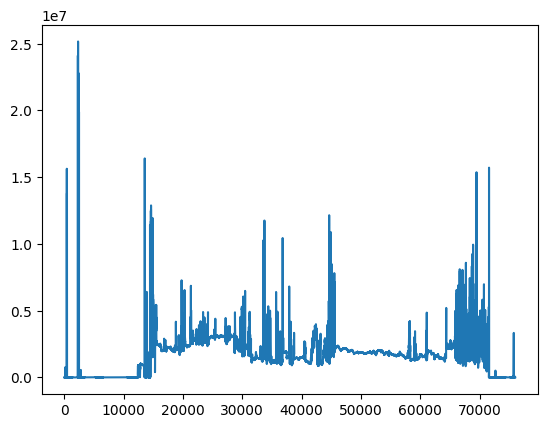

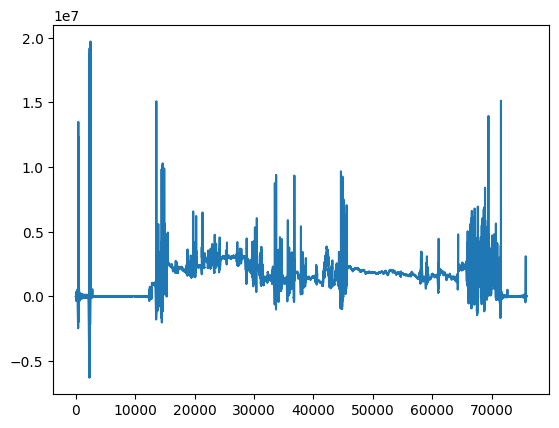

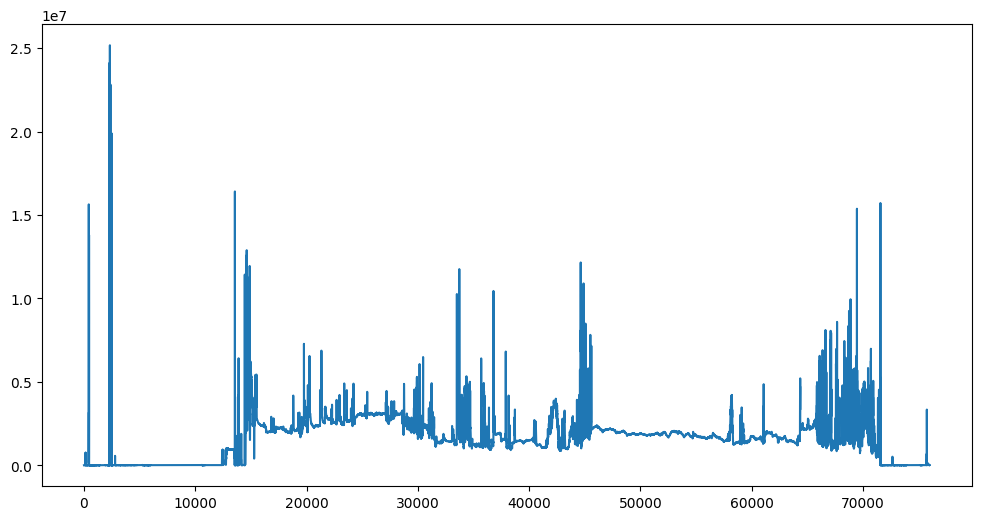

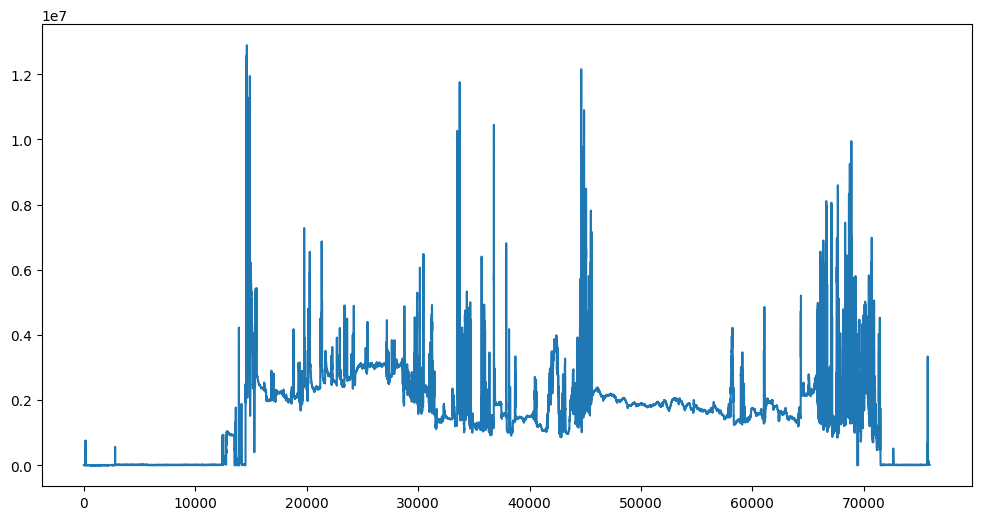

In [34]:
raw = df['ppg'].values

plt.plot(raw)
plt.show()

import sys
from scipy.signal import resample

windowsize = 100
std = []

for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    try:
        std.append(np.std(sliced))
    except:
        print(i)

plt.plot(std)
plt.show()

plt.plot(raw)
plt.show()

plt.plot(raw[0:(len(raw) // windowsize) * windowsize] - resample(std, len(std)*windowsize))
plt.show()

(len(raw) // windowsize) * windowsize


mx = np.max(raw)
mn = np.min(raw)
global_range = mx - mn

windowsize = 100
filtered = []

for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    rng = np.max(sliced) - np.min(sliced)

    if ((rng >= (0.5 * global_range))
        or
        (np.max(sliced) >= 0.9 * mx)
        or
        (np.min(sliced) <= mn + (0.1 * mn))):

        for x in sliced:
            filtered.append(0)
    else:
        for x in sliced:
            filtered.append(x)

plt.figure(figsize=(12,6))
plt.plot(raw)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered)
plt.show()

/Users/victorrubia/Desktop/TFG/backend/lib/python/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/victorrubia/Desktop/TFG/backend/lib/python/heartpy/visualizeutils.py:299: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


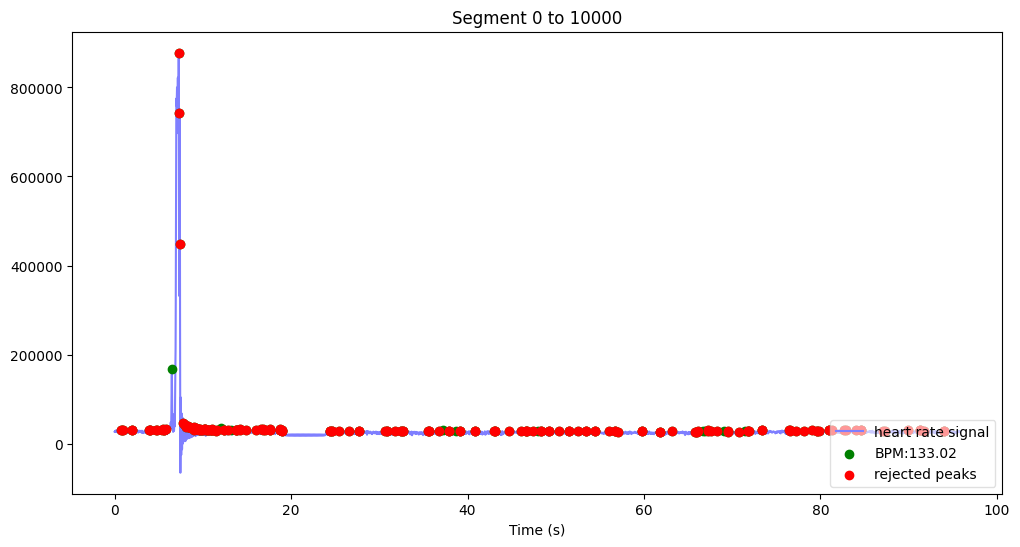

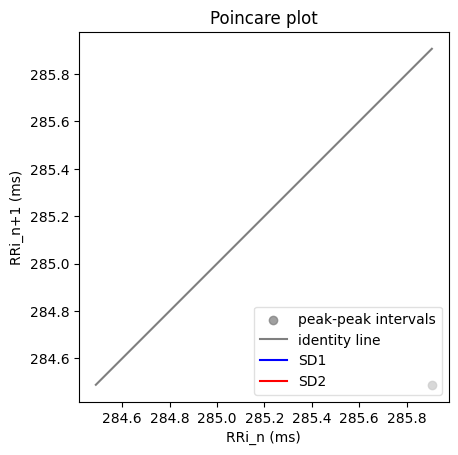

MEAN_REL_RR: 0.010559
MEDIAN_REL_RR: -0.011890
SDRR_REL_RR: 1.727906
RMSSD_REL_RR: 0.222049
SDRR_RMSSD_REL_RR: 7.781633
Mo: 0.582967
VR: 5440.219033
AMo: 5.945946
SI: 0.093741
bpm: 133.023178
ibi: 451.049213
sdnn: 184.135040
sdsd: 0.000000
rmssd: 1.417033
pnn20: 0.000000
pnn50: 0.000000
hr_mad: 105.412633
sd1: 0.000000
sd2: 0.000000
s: 0.000000
sd1/sd2: nan
breathingrate: 0.222025


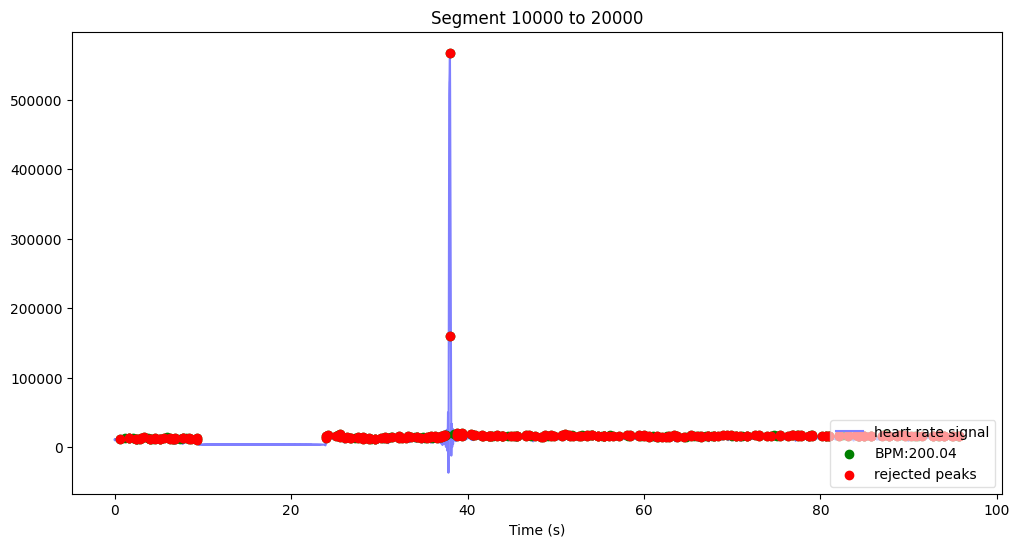

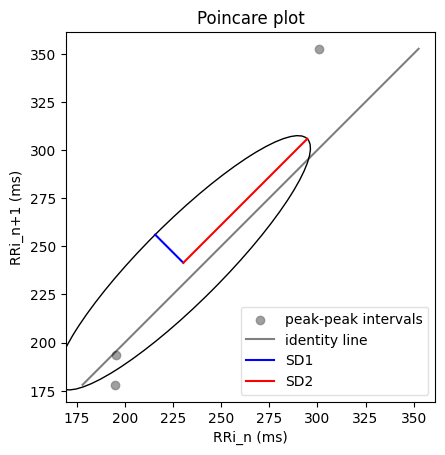

MEAN_REL_RR: 0.061705
MEDIAN_REL_RR: -0.194031
SDRR_REL_RR: 2.625849
RMSSD_REL_RR: 0.249004
SDRR_RMSSD_REL_RR: 10.545392
Mo: 0.582967
VR: 14716.445600
AMo: 2.105263
SI: 0.012270
bpm: 200.039209
ibi: 299.941198
sdnn: 129.640625
sdsd: 20.852604
rmssd: 31.252159
pnn20: 0.333333
pnn50: 0.333333
hr_mad: 103.121150
sd1: 20.670147
sd2: 91.034863
s: 5911.547444
sd1/sd2: 0.227057
breathingrate: 0.298223


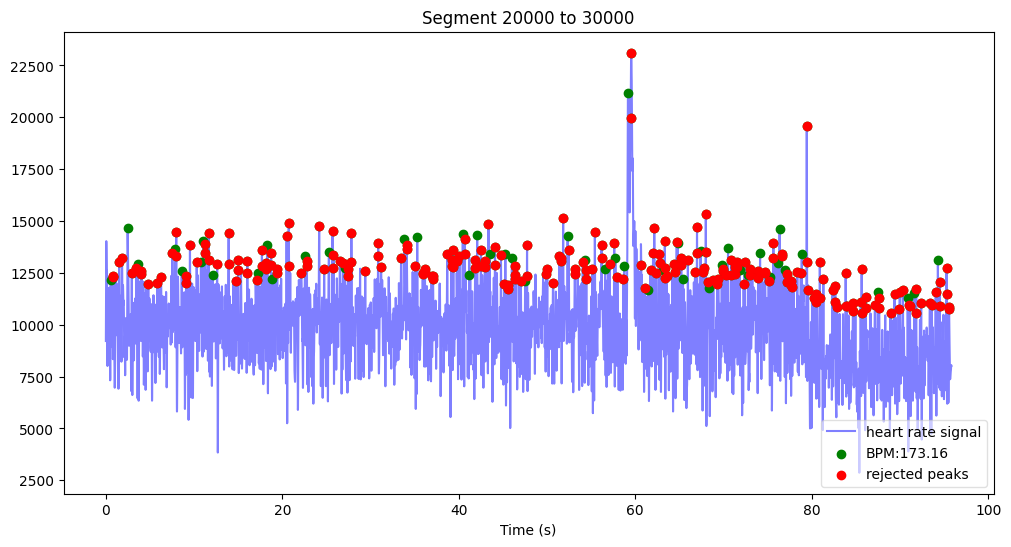

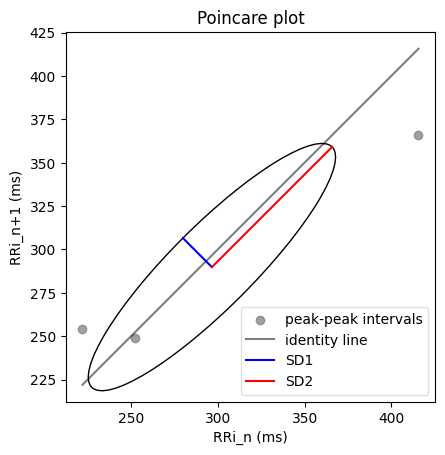

MEAN_REL_RR: -0.043745
MEDIAN_REL_RR: -0.147406
SDRR_REL_RR: 1.558024
RMSSD_REL_RR: 0.167223
SDRR_RMSSD_REL_RR: 9.317042
Mo: 0.582967
VR: 2366.499367
AMo: 4.029304
SI: 0.146033
bpm: 173.162404
ibi: 346.495535
sdnn: 150.307620
sdsd: 19.186484
rmssd: 34.125648
pnn20: 0.666667
pnn50: 0.000000
hr_mad: 124.578567
sd1: 23.649822
sd2: 97.960406
s: 7278.272812
sd1/sd2: 0.241422
breathingrate: 0.294950


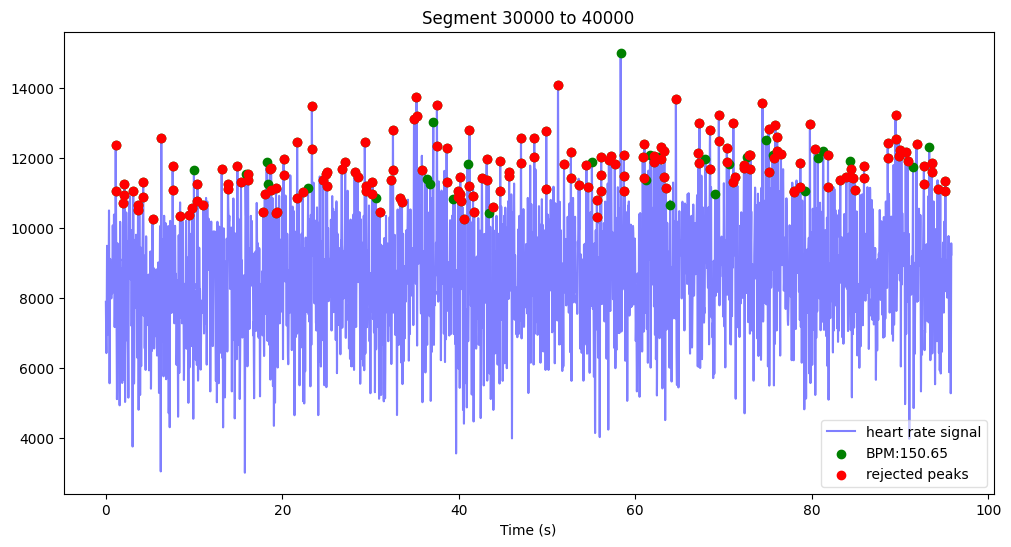

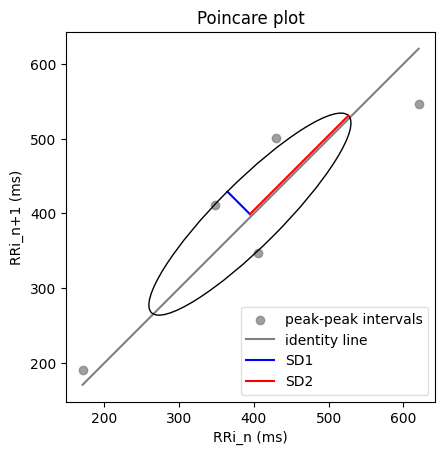

MEAN_REL_RR: -0.063477
MEDIAN_REL_RR: -0.199351
SDRR_REL_RR: 1.572172
RMSSD_REL_RR: 0.194222
SDRR_RMSSD_REL_RR: 8.094696
Mo: 0.582967
VR: 2695.566933
AMo: 5.288462
SI: 0.168270
bpm: 150.654359
ibi: 398.262622
sdnn: 138.154077
sdsd: 19.597823
rmssd: 60.525289
pnn20: 0.800000
pnn50: 0.800000
hr_mad: 116.287083
sd1: 42.681156
sd2: 186.301198
s: 24980.532424
sd1/sd2: 0.229098
breathingrate: 0.251425


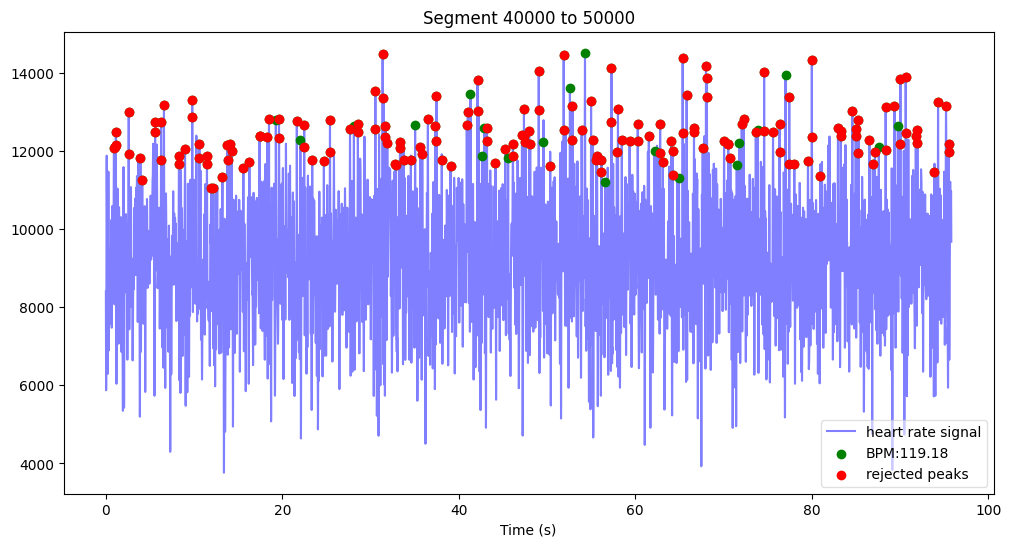

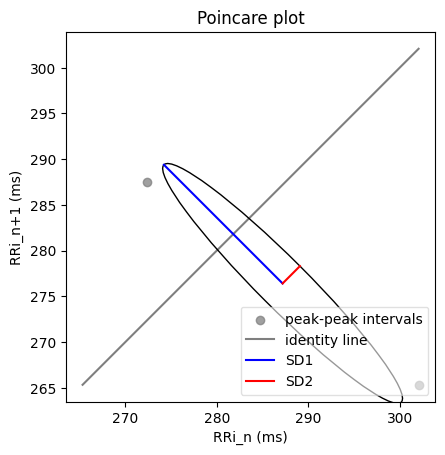

MEAN_REL_RR: -0.070280
MEDIAN_REL_RR: -0.067883
SDRR_REL_RR: 1.596839
RMSSD_REL_RR: 0.208865
SDRR_RMSSD_REL_RR: 7.645308
Mo: 0.165933
VR: 2361.333433
AMo: 2.688172
SI: 0.343033
bpm: 119.176313
ibi: 503.455750
sdnn: 190.129506
sdsd: 10.791483
rmssd: 28.111272
pnn20: 0.500000
pnn50: 0.000000
hr_mad: 160.118950
sd1: 18.354665
sd2: 2.680984
s: 154.593239
sd1/sd2: 6.846243
breathingrate: 0.099404


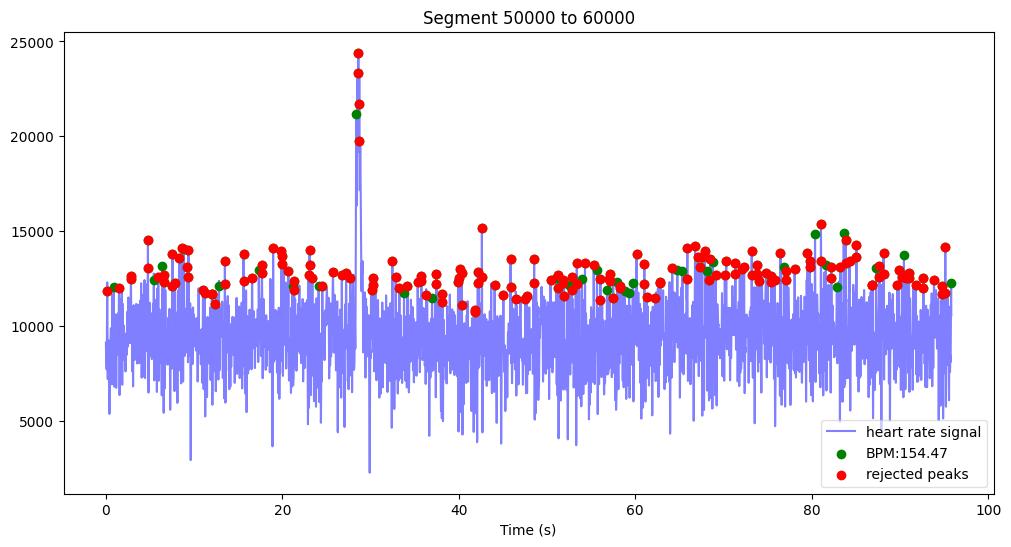

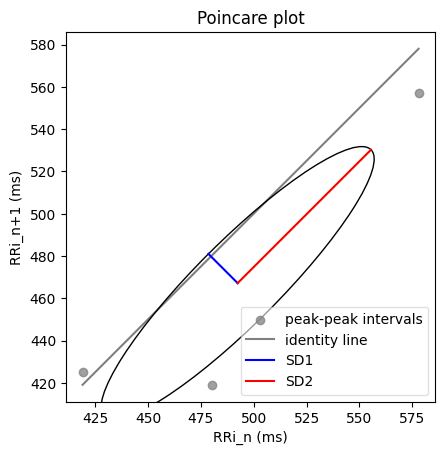

MEAN_REL_RR: -0.084841
MEDIAN_REL_RR: -0.222025
SDRR_REL_RR: 1.526070
RMSSD_REL_RR: 0.191021
SDRR_RMSSD_REL_RR: 7.988999
Mo: 0.165933
VR: 2218.835633
AMo: 3.883495
SI: 0.527393
bpm: 154.465262
ibi: 388.436852
sdnn: 142.328040
sdsd: 23.215931
rmssd: 37.428838
pnn20: 0.666667
pnn50: 0.333333
hr_mad: 95.829667
sd1: 19.537759
sd2: 89.209089
s: 5475.625192
sd1/sd2: 0.219011
breathingrate: 0.332640


BadSignalWarning: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------


In [46]:
from scipy.signal import resample

resampled = resample(filtered, len(filtered) * 5)

#don't forget to compute the new sampling rate
new_sample_rate = sample_rate * 5

#run HeartPy over a few segments, fingers crossed, and plot results of each
for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
    wd, m = hp.process(resampled[s[0]:s[1]], sample_rate = new_sample_rate,
                       high_precision=True, clean_rr=True)
    hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    hp.plot_poincare(wd, m)
    plt.show()
    for measure in m.keys():
        print('%s: %f' %(measure, m[measure]))